Found eigenvalues: [0.025094706577910762, 0.09939399318851948, 0.10164380308345752, 0.10711154951514149, 0.2199609972803645, 0.22677994825496545, 0.23889261345910956, 0.3823935758671656, 0.3987894885939089, 0.42073773934356434, 0.5827316100395981, 0.6154852323303296, 0.6516008783591963, 0.8205024728529049, 0.875774425518025, 0.9308885068251811, 1.099815180363309, 1.1805531936810758, 1.2583039595449097, 1.4263109034701453, 1.5320147097436243, 1.6337615107284804, 1.8035380573346933, 1.932072269044371, 2.057327582174719, 2.2324839299116848, 2.381706882836575, 2.529162140804377, 2.7128790882376337, 2.8812206980753117, 3.049465209955102, 3.244170208502994, 3.4306105869946273, 3.6184371555563986, 3.825874086185534, 4.029779948566731, 4.2362552872484045, 4.457640456936272, 4.678623705896198, 4.903064119460751]
Attempting to plot the first 13 eigenstates.


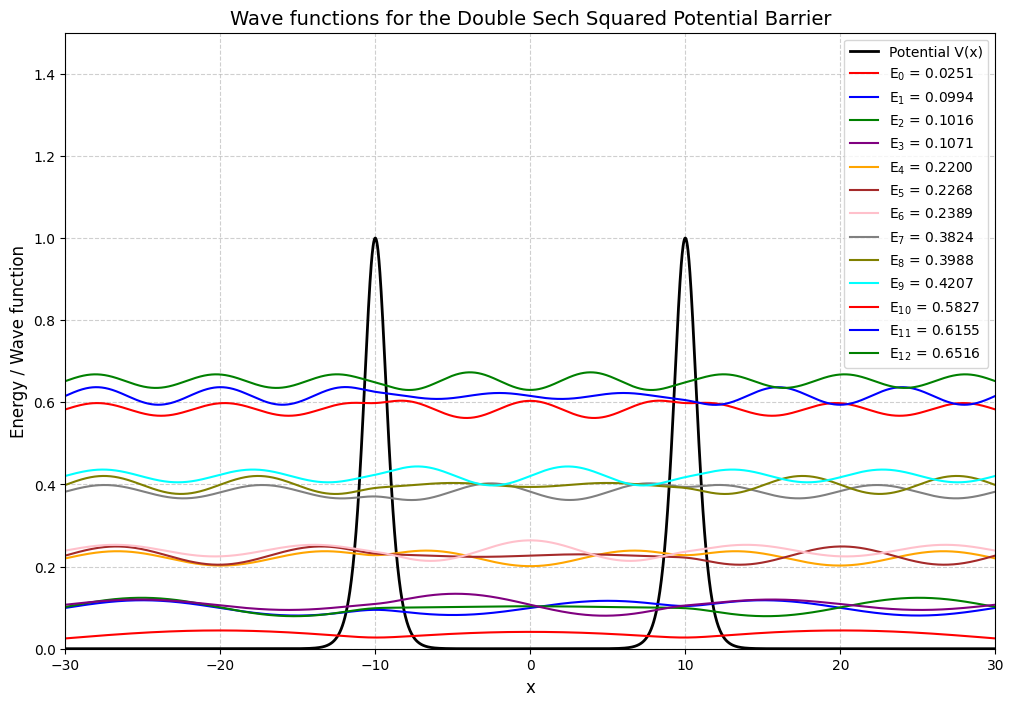

In [1]:
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import simpson
import matplotlib.pyplot as plt

def potential(x, b, a, c):
    """
    Potential function V(x) = b(sech^2((x - a) / c) + sech^2((x + a) / c))
    For positive b, this represents a potential barrier.
    """
    return b / np.cosh((x - a) / c)**2 + b / np.cosh((x + a) / c)**2

def numerov_step(psi_prev, psi_curr, k_prev_sq, k_curr_sq, k_next_sq, dx):
    """
    Applies the Numerov method to find the next point of the wave function.
    Based on the formula:
    psi(x+dx) * (1 + dx^2/12 * k(x+dx)^2) = 2*psi(x) * (1 - 5*dx^2/12 * k(x)^2) - psi(x-dx) * (1 + dx^2/12 * k(x-dx)^2)
    where k(x)^2 = 2m/hbar^2 * (E - V(x)).
    We use units where 2m/hbar^2 = 1 for simplicity, so k^2 = E - V(x).
    """
    # Handle potential barriers where k^2 can be negative. The formula holds directly.
    denom = 1 + dx**2 / 12 * k_next_sq
    if abs(denom) < 1e-10: # Avoid division by near zero
        return np.nan # Return NaN to indicate an issue

    psi_next = (2 * psi_curr * (1 - 5 * dx**2 / 12 * k_curr_sq) -
                psi_prev * (1 + dx**2 / 12 * k_prev_sq)) / denom
    return psi_next


def solve_schrodinger_single_sweep(energy, x, dx, potential_func, params):
    """
    Solves the time-independent Schrödinger equation for a given energy
    using the Numerov method by integrating from the left boundary to the right.
    Assumes hard wall boundary condition psi(x_min) = 0.
    Returns the unnormalized wave function. Uses units where 2m/hbar^2 = 1.
    """
    n_points = len(x)
    psi = np.zeros(n_points)
    psi[0] = 0.0  # Boundary condition at x_min
    psi[1] = 1e-5 * dx  # Small arbitrary non-zero value for psi(x_min + dx)

    k2 = energy - potential_func(x, *params)

    # Apply Numerov method
    for i in range(1, n_points - 1):
        # Ensure indices for k2 are within bounds.
        k_prev_sq = k2[i-1]
        k_curr_sq = k2[i]
        k_next_sq = k2[i+1] if i + 1 < n_points else k2[i] # Approximation for the last step

        psi[i+1] = numerov_step(psi[i-1], psi[i], k_prev_sq, k_curr_sq, k_next_sq, dx)

        if np.isnan(psi[i+1]): # Check for numerical stability issues
             return np.full(n_points, np.nan)


    return psi


def shoot_mismatch(energy, x, dx, potential_func, params):
    """
    Calculates the mismatch for the shooting method with hard wall boundary conditions.
    Integrates from the left boundary and returns the value of the wave function
    at the right boundary. For eigenvalues, this value should be zero.
    Uses units where 2m/hbar^2 = 1.
    """
    psi = solve_schrodinger_single_sweep(energy, x, dx, potential_func, params)
    if np.isnan(psi).any():
        return np.inf # Return large value if integration failed
    return psi[-1] # Value of psi at the right boundary

def normalize_wavefunction(psi, dx):
    """
    Normalizes the wave function using Simpson's rule for integration.
    Returns zero array if normalization is not possible (e.g., all psi are zero or NaN).
    """
    norm_squared = simpson(np.abs(psi)**2, dx=dx)
    if norm_squared > 1e-15: # Avoid division by zero or near zero
        return psi / np.sqrt(norm_squared)
    else:
        return np.zeros_like(psi)


# --- Parameters ---
# Using units where hbar=1 and 2m=1. Energy will be in arbitrary units.
b = 1.0  # Potential parameter (positive for a barrier)
a = 10.0  # Potential parameter
c = 1.0  # Potential parameter

# Spatial grid
x_min = -30.0
x_max = 30.0
n_points = 3001
x, dx = np.linspace(x_min, x_max, n_points, retstep=True)

# Potential on the grid
v_x = potential(x, b, a, c)

# Number of eigenstates to plot
num_eigenstates_to_plot = 13 # You can change this value

# --- Shooting Method to find Eigenvalues ---
# For a positive barrier with hard wall boundary conditions, the energies are positive.
# The energy search range starts from a value slightly above the minimum of the potential
# within the box (which is V(x_min) = V(x_max) = potential at the boundaries, which is close to 0).
# The upper limit of the search needs to be high enough to capture the desired number of eigenvalues.
# A rough estimate for the energy levels in a box of length L is E_n ~ n^2 * pi^2 / (2m * L^2).
# Here L = x_max - x_min = 20. In our units (2m=1), E_n ~ n^2 * pi^2 / L^2.
# For n=5, E_5 ~ 25 * pi^2 / 400 ~ 25 * 9.87 / 400 ~ 0.6
# Let's search in a range that should include the first few levels.

energy_min_search = 0.0  # Energies are positive for a positive potential in a box
energy_max_search = b * 5 # Adjust this based on the potential shape and desired number of states. Or use a higher value.

# Create a range of test energies to find sign changes
# We need enough points to catch the oscillations of the wave function at the boundary
# The number of oscillations increases with energy.
# A higher density of test points might be needed for higher energy states.
num_test_energies = 1000
energies_test = np.linspace(energy_min_search, energy_max_search, num_test_energies)

# Calculate the mismatch (wave function value at the right boundary) for each test energy
mismatch_values = [shoot_mismatch(E, x, dx, potential, (b, a, c)) for E in energies_test]

# Find where the sign of mismatch_values changes to locate approximate eigenvalues
# Filter out intervals where mismatch is NaN
valid_indices = ~np.isnan(mismatch_values)
valid_energies_test = energies_test[valid_indices]
valid_mismatch_values = np.array(mismatch_values)[valid_indices]


sign_changes = np.where(np.sign(valid_mismatch_values[:-1]) != np.sign(valid_mismatch_values[1:]))[0]

eigenvalues = []

# Use brentq to find the accurate eigenvalue in each interval where a sign change occurred
for i in sign_changes:
    try:
        eigenvalue = brentq(shoot_mismatch, valid_energies_test[i], valid_energies_test[i+1],
                            args=(x, dx, potential, (b, a, c)))
        eigenvalues.append(eigenvalue)
    except ValueError:
        # brentq might fail if there are no roots in the interval (e.g., false sign change)
        pass

# Sort the eigenvalues in ascending order
eigenvalues.sort()

print("Found eigenvalues:", eigenvalues)
print(f"Attempting to plot the first {num_eigenstates_to_plot} eigenstates.")

# --- Calculate and Normalize Wave Functions for the first n Eigenvalues ---
wavefunctions = []

# Select the first num_eigenstates_to_plot eigenvalues
eigenvalues_to_plot = eigenvalues[:num_eigenstates_to_plot]

for eigenvalue in eigenvalues_to_plot:
    # Solve the Schrödinger equation for the found eigenvalue using a single sweep
    unnormalized_psi = solve_schrodinger_single_sweep(eigenvalue, x, dx, potential, (b, a, c))

    # Normalize the wave function
    normalized_psi = normalize_wavefunction(unnormalized_psi, dx)
    wavefunctions.append(normalized_psi)

# --- Plotting ---
plt.figure(figsize=(12, 8))
plt.plot(x, v_x, label="Potential V(x)", color='black', linewidth=2)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i, E in enumerate(eigenvalues_to_plot):
    if i < len(wavefunctions) and not np.isnan(wavefunctions[i]).any():
        # Plot wave function shifted by the energy for better visualization
        plt.plot(x, wavefunctions[i] * (max(v_x) - min(v_x)) * 0.1 + E, label=f"E$_{{{i}}}$ = {E:.4f}", color=colors[i % len(colors)]) # Scale psi for plotting

plt.xlabel("x", fontsize=12)
plt.ylabel("Energy / Wave function", fontsize=12)
plt.title("Wave functions for the Double Sech Squared Potential Barrier", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(min(v_x) * 1.1, max(v_x) * 1.5) # Adjust y-limits for better visualization
plt.xlim(x_min, x_max)
plt.show()

Found eigenvalues: [0.025094706577910762, 0.09939399318851948, 0.10164380308345752, 0.10711154951514149, 0.2199609972803645, 0.22677994825496545, 0.23889261345910956, 0.3823935758671656, 0.3987894885939089, 0.42073773934356434, 0.5827316100395981, 0.6154852323303296, 0.6516008783591963, 0.8205024728529049, 0.875774425518025, 0.9308885068251811, 1.099815180363309, 1.1805531936810758, 1.2583039595449097, 1.4263109034701453, 1.5320147097436243, 1.6337615107284804, 1.8035380573346933, 1.932072269044371, 2.057327582174719, 2.2324839299116848, 2.381706882836575, 2.529162140804377, 2.7128790882376337, 2.8812206980753117, 3.049465209955102, 3.244170208502994, 3.4306105869946273, 3.6184371555563986, 3.825874086185534, 4.029779948566731, 4.2362552872484045, 4.457640456936272, 4.678623705896198, 4.903064119460751]
Attempting to plot the first 20 eigenstates.


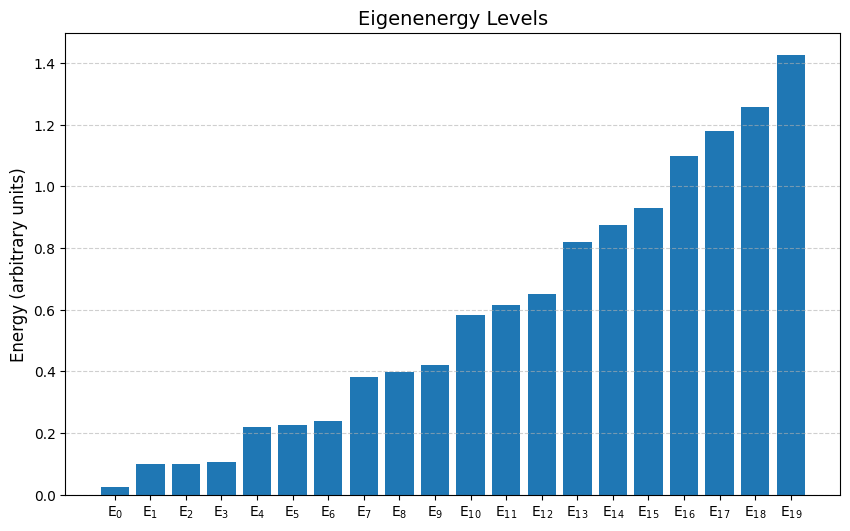

In [4]:
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import simpson
import matplotlib.pyplot as plt

def potential(x, b, a, c):
    """
    Potential function V(x) = b(sech^2((x - a) / c) + sech^2((x + a) / c))
    For positive b, this represents a potential barrier.
    """
    return b / np.cosh((x - a) / c)**2 + b / np.cosh((x + a) / c)**2

def numerov_step(psi_prev, psi_curr, k_prev_sq, k_curr_sq, k_next_sq, dx):
    """
    Applies the Numerov method to find the next point of the wave function.
    Based on the formula:
    psi(x+dx) * (1 + dx^2/12 * k(x+dx)^2) = 2*psi(x) * (1 - 5*dx^2/12 * k(x)^2) - psi(x-dx) * (1 + dx^2/12 * k(x-dx)^2)
    where k(x)^2 = 2m/hbar^2 * (E - V(x)).
    We use units where 2m/hbar^2 = 1 for simplicity, so k^2 = E - V(x).
    """
    # Handle potential barriers where k^2 can be negative. The formula holds directly.
    denom = 1 + dx**2 / 12 * k_next_sq
    if abs(denom) < 1e-10: # Avoid division by near zero
        return np.nan # Return NaN to indicate an issue

    psi_next = (2 * psi_curr * (1 - 5 * dx**2 / 12 * k_curr_sq) -
                  psi_prev * (1 + dx**2 / 12 * k_prev_sq)) / denom
    return psi_next


def solve_schrodinger_single_sweep(energy, x, dx, potential_func, params):
    """
    Solves the time-independent Schrödinger equation for a given energy
    using the Numerov method by integrating from the left boundary to the right.
    Assumes hard wall boundary condition psi(x_min) = 0.
    Returns the unnormalized wave function. Uses units where 2m/hbar^2 = 1.
    """
    n_points = len(x)
    psi = np.zeros(n_points)
    psi[0] = 0.0  # Boundary condition at x_min
    psi[1] = 1e-5 * dx  # Small arbitrary non-zero value for psi(x_min + dx)

    k2 = energy - potential_func(x, *params)

    # Apply Numerov method
    for i in range(1, n_points - 1):
        # Ensure indices for k2 are within bounds.
        k_prev_sq = k2[i-1]
        k_curr_sq = k2[i]
        k_next_sq = k2[i+1] if i + 1 < n_points else k2[i] # Approximation for the last step

        psi[i+1] = numerov_step(psi[i-1], psi[i], k_prev_sq, k_curr_sq, k_next_sq, dx)

        if np.isnan(psi[i+1]): # Check for numerical stability issues
             return np.full(n_points, np.nan)


    return psi


def shoot_mismatch(energy, x, dx, potential_func, params):
    """
    Calculates the mismatch for the shooting method with hard wall boundary conditions.
    Integrates from the left boundary and returns the value of the wave function
    at the right boundary. For eigenvalues, this value should be zero.
    Uses units where 2m/hbar^2 = 1.
    """
    psi = solve_schrodinger_single_sweep(energy, x, dx, potential_func, params)
    if np.isnan(psi).any():
        return np.inf # Return large value if integration failed
    return psi[-1] # Value of psi at the right boundary

def normalize_wavefunction(psi, dx):
    """
    Normalizes the wave function using Simpson's rule for integration.
    Returns zero array if normalization is not possible (e.g., all psi are zero or NaN).
    """
    norm_squared = simpson(np.abs(psi)**2, dx=dx)
    if norm_squared > 1e-15: # Avoid division by zero or near zero
        return psi / np.sqrt(norm_squared)
    else:
        return np.zeros_like(psi)


# --- Parameters ---
# Using units where hbar=1 and 2m=1. Energy will be in arbitrary units.
b = 1.0  # Potential parameter (positive for a barrier)
a = 10.0  # Potential parameter
c = 1.0  # Potential parameter

# Spatial grid
x_min = -30.0
x_max = 30.0
n_points = 3001
x, dx = np.linspace(x_min, x_max, n_points, retstep=True)

# Potential on the grid
v_x = potential(x, b, a, c)

# Number of eigenstates to plot
num_eigenstates_to_plot = 20 # You can change this value

# --- Shooting Method to find Eigenvalues ---
# For a positive barrier with hard wall boundary conditions, the energies are positive.
# The energy search range starts from a value slightly above the minimum of the potential
# within the box (which is V(x_min) = V(x_max) = potential at the boundaries, which is close to 0).
# The upper limit of the search needs to be high enough to capture the desired number of eigenvalues.
# A rough estimate for the energy levels in a box of length L is E_n ~ n^2 * pi^2 / (2m * L^2).
# Here L = x_max - x_min = 20. In our units (2m=1), E_n ~ n^2 * pi^2 / L^2.
# For n=5, E_5 ~ 25 * pi^2 / 400 ~ 0.6
# Let's search in a range that should include the first few levels.

energy_min_search = 0.0  # Energies are positive for a positive potential in a box
energy_max_search = b * 5 # Adjust this based on the potential shape and desired number of states. Or use a higher value.

# Create a range of test energies to find sign changes
# We need enough points to catch the oscillations of the wave function at the boundary
# The number of oscillations increases with energy.
# A higher density of test points might be needed for higher energy states.
num_test_energies = 1000
energies_test = np.linspace(energy_min_search, energy_max_search, num_test_energies)

# Calculate the mismatch (wave function value at the right boundary) for each test energy
mismatch_values = [shoot_mismatch(E, x, dx, potential, (b, a, c)) for E in energies_test]

# Find where the sign of mismatch_values changes to locate approximate eigenvalues
# Filter out intervals where mismatch is NaN
valid_indices = ~np.isnan(mismatch_values)
valid_energies_test = energies_test[valid_indices]
valid_mismatch_values = np.array(mismatch_values)[valid_indices]


sign_changes = np.where(np.sign(valid_mismatch_values[:-1]) != np.sign(valid_mismatch_values[1:]))[0]

eigenvalues = []

# Use brentq to find the accurate eigenvalue in each interval where a sign change occurred
for i in sign_changes:
    try:
        eigenvalue = brentq(shoot_mismatch, valid_energies_test[i], valid_energies_test[i+1],
                                         args=(x, dx, potential, (b, a, c)))
        eigenvalues.append(eigenvalue)
    except ValueError:
        # brentq might fail if there are no roots in the interval (e.g., false sign change)
        pass

# Sort the eigenvalues in ascending order
eigenvalues.sort()

print("Found eigenvalues:", eigenvalues)
print(f"Attempting to plot the first {num_eigenstates_to_plot} eigenstates.")

# --- Calculate and Normalize Wave Functions for the first n Eigenvalues ---
wavefunctions = []

# Select the first num_eigenstates_to_plot eigenvalues
eigenvalues_to_plot = eigenvalues[:num_eigenstates_to_plot]

for eigenvalue in eigenvalues_to_plot:
    # Solve the Schrödinger equation for the found eigenvalue using a single sweep
    unnormalized_psi = solve_schrodinger_single_sweep(eigenvalue, x, dx, potential, (b, a, c))

    # Normalize the wave function
    normalized_psi = normalize_wavefunction(unnormalized_psi, dx)
    wavefunctions.append(normalized_psi)

# --- Plotting Eigenvalues ---
plt.figure(figsize=(10, 6))
plt.bar(range(len(eigenvalues_to_plot)), eigenvalues_to_plot)
plt.xticks(range(len(eigenvalues_to_plot)), [f'E$_{{{i}}}$' for i in range(len(eigenvalues_to_plot))])
plt.ylabel("Energy (arbitrary units)", fontsize=12)
plt.title("Eigenenergy Levels", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Calculating eigenvalues for a = 5.0
Found 36 eigenvalues for a = 5.0
Calculating eigenvalues for a = 10.0
Found 40 eigenvalues for a = 10.0
Calculating eigenvalues for a = 15.0
Found 40 eigenvalues for a = 15.0


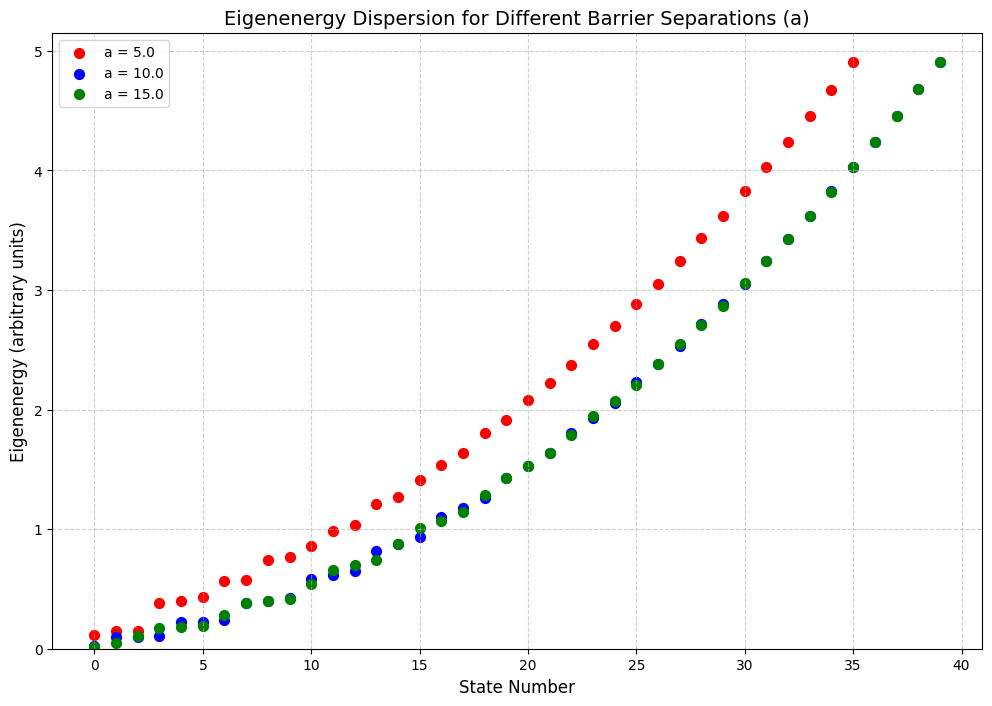

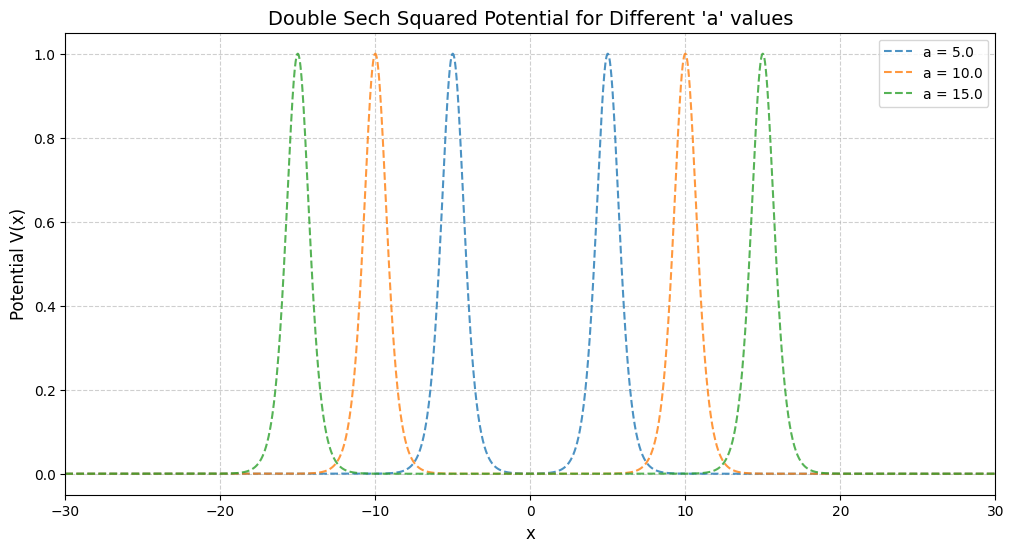

In [5]:
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import simpson
import matplotlib.pyplot as plt

def potential(x, b, a, c):
    """
    Potential function V(x) = b(sech^2((x - a) / c) + sech^2((x + a) / c))
    For positive b, this represents a potential barrier.
    """
    return b / np.cosh((x - a) / c)**2 + b / np.cosh((x + a) / c)**2

def numerov_step(psi_prev, psi_curr, k_prev_sq, k_curr_sq, k_next_sq, dx):
    """
    Applies the Numerov method to find the next point of the wave function.
    Based on the formula:
    psi(x+dx) * (1 + dx^2/12 * k(x+dx)^2) = 2*psi(x) * (1 - 5*dx^2/12 * k(x)^2) - psi(x-dx) * (1 + dx^2/12 * k(x-dx)^2)
    where k(x)^2 = 2m/hbar^2 * (E - V(x)).
    We use units where 2m/hbar^2 = 1 for simplicity, so k^2 = E - V(x).
    """
    denom = 1 + dx**2 / 12 * k_next_sq
    if abs(denom) < 1e-10:
        return np.nan

    psi_next = (2 * psi_curr * (1 - 5 * dx**2 / 12 * k_curr_sq) -
                  psi_prev * (1 + dx**2 / 12 * k_prev_sq)) / denom
    return psi_next


def solve_schrodinger_single_sweep(energy, x, dx, potential_func, params):
    """
    Solves the time-independent Schrödinger equation for a given energy
    using the Numerov method by integrating from the left boundary to the right.
    Assumes hard wall boundary condition psi(x_min) = 0.
    Returns the unnormalized wave function. Uses units where 2m/hbar^2 = 1.
    """
    n_points = len(x)
    psi = np.zeros(n_points)
    psi[0] = 0.0
    psi[1] = 1e-5 * dx

    # Update params tuple to use the current 'a' value passed in params
    current_b, current_a, current_c = params
    k2 = energy - potential_func(x, current_b, current_a, current_c)

    for i in range(1, n_points - 1):
        k_prev_sq = k2[i-1]
        k_curr_sq = k2[i]
        k_next_sq = k2[i+1] if i + 1 < n_points else k2[i]

        psi[i+1] = numerov_step(psi[i-1], psi[i], k_prev_sq, k_curr_sq, k_next_sq, dx)

        if np.isnan(psi[i+1]):
             return np.full(n_points, np.nan)

    return psi


def shoot_mismatch(energy, x, dx, potential_func, params):
    """
    Calculates the mismatch for the shooting method.
    """
    psi = solve_schrodinger_single_sweep(energy, x, dx, potential_func, params)
    if np.isnan(psi).any():
        return np.inf
    return psi[-1]


# --- Parameters ---
b = 1.0
# We will iterate over 'a'
c = 1.0

# Spatial grid
x_min = -30.0
x_max = 30.0
n_points = 3001
x, dx = np.linspace(x_min, x_max, n_points, retstep=True)

# List of 'a' values to test
a_values = [5.0, 10.0, 15.0]

# Store results
eigenvalues_by_a = {}

# --- Loop through 'a' values and find eigenvalues ---
for current_a in a_values:
    print(f"Calculating eigenvalues for a = {current_a}")

    # Potential on the grid for the current 'a'
    v_x = potential(x, b, current_a, c)

    # Adjust search range based on the potential height (b)
    energy_min_search = 0.0
    energy_max_search = b * 5 # Max energy to search for

    num_test_energies = 1000
    energies_test = np.linspace(energy_min_search, energy_max_search, num_test_energies)

    # Calculate the mismatch for each test energy
    # Pass the current 'a' value in the params tuple
    mismatch_values = [shoot_mismatch(E, x, dx, potential, (b, current_a, c)) for E in energies_test]

    valid_indices = ~np.isnan(mismatch_values)
    valid_energies_test = energies_test[valid_indices]
    valid_mismatch_values = np.array(mismatch_values)[valid_indices]

    sign_changes = np.where(np.sign(valid_mismatch_values[:-1]) != np.sign(valid_mismatch_values[1:]))[0]

    eigenvalues = []

    # Use brentq to find the accurate eigenvalue
    for i in sign_changes:
        try:
            # Pass the current 'a' value in the params tuple
            eigenvalue = brentq(shoot_mismatch, valid_energies_test[i], valid_energies_test[i+1],
                                             args=(x, dx, potential, (b, current_a, c)))
            eigenvalues.append(eigenvalue)
        except ValueError:
            pass

    eigenvalues.sort()
    print(f"Found {len(eigenvalues)} eigenvalues for a = {current_a}")
    eigenvalues_by_a[current_a] = eigenvalues

# --- Plotting Dispersion Plot ---
plt.figure(figsize=(12, 8))

# Use different colors for each 'a' value
colors = {5.0: 'red', 10.0: 'blue', 15.0: 'green'}

for current_a, eigenvalues in eigenvalues_by_a.items():
    # State numbers are 0-indexed
    state_numbers = np.arange(len(eigenvalues))
    plt.scatter(state_numbers, eigenvalues, label=f'a = {current_a}', color=colors[current_a], s=50) # s is marker size

plt.xlabel("State Number", fontsize=12)
plt.ylabel("Eigenenergy (arbitrary units)", fontsize=12)
plt.title("Eigenenergy Dispersion for Different Barrier Separations (a)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(bottom=0) # Ensure energy starts from 0
plt.show()

# Optional: Plot the potential for different 'a' values to see how it changes
plt.figure(figsize=(12, 6))
for current_a in a_values:
    v_x = potential(x, b, current_a, c)
    plt.plot(x, v_x, label=f'a = {current_a}', linestyle='--', alpha=0.8)

plt.xlabel("x", fontsize=12)
plt.ylabel("Potential V(x)", fontsize=12)
plt.title("Double Sech Squared Potential for Different 'a' values", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(x_min, x_max)
plt.show()